In [5]:
import openslide, numpy as np
import cv2
from cv2 import filter2D
import matplotlib.pyplot as plt
import tqdm
from sklearn.cluster import KMeans
import os
import bitarray
from bitarray import util as butil

os.environ['NVIDIA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import tensorflow as tf

%matplotlib inline

/home/blansdell/anaconda3/envs/clam/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/blansdell/anaconda3/envs/clam/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/blansdell/anaconda3/envs/clam/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/blansdell/anaconda3/envs/clam/lib/pyt

In [6]:
class BoB:
    
    def __init__(self, barcodes):
        self.barcodes = [bitarray.bitarray(b.tolist()) for b in barcodes]
        
    def select_subset(self, n = 3):
        idx = np.arange(len(self.barcodes))
        np.random.shuffle(idx)
        idx = idx[:n]
        
        return BoB(barcodes=[self.barcodes[i] for i in idx])
    
    def distance(self, bob):

        total_dist = []
        for feat in self.barcodes:
            distances = [butil.count_xor(feat, b) for b in bob.barcodes]
            total_dist.append(np.min(distances))

        retval = np.median(total_dist)

        return retval

In [7]:
def preprocessing_fn(inp, sz=(1000, 1000)):

    out = tf.cast(inp, 'float') / 255.
    
    out = tf.cond(tf.equal(tf.shape(inp)[1], sz[0]), 
                lambda: out, lambda: tf.image.resize(out, sz))
    
    mean = tf.reshape((0.485, 0.456, 0.406), [1, 1, 1, 3])
    std = tf.reshape((0.229, 0.224, 0.225), [1, 1, 1, 3])
    
    out = out - mean
    out = out / std
    
    return out


def get_dn121_model():
    model = tf.keras.applications.densenet.DenseNet121(input_shape=(1000, 1000, 3),\
                                                       include_top=False,\
                                                       pooling='avg')
    
    seq_model = tf.keras.models.Sequential([tf.keras.layers.Lambda(preprocessing_fn,\
                                                   input_shape=(None, None, 3),\
                                                   dtype=tf.uint8)])
    seq_model.add(model)
    return seq_model

# https://github.com/FarhadZanjani/Histopathology-Stain-Color-Normalization/blob/master/ops.py
def RGB2HSD(X):
    eps = np.finfo(float).eps
    X[np.where(X==0.0)] = eps
    
    OD = -np.log(X / 1.0)
    D  = np.mean(OD,3)
    D[np.where(D==0.0)] = eps
    
    cx = OD[:,:,:,0] / (D) - 1.0
    cy = (OD[:,:,:,1]-OD[:,:,:,2]) / (np.sqrt(3.0)*D)
    
    D = np.expand_dims(D,3)
    cx = np.expand_dims(cx,3)
    cy = np.expand_dims(cy,3)
            
    X_HSD = np.concatenate((D,cx,cy),3)
    return X_HSD


def clean_thumbnail(thumbnail):
    thumbnail_arr = np.asarray(thumbnail)
    
    # writable thumbnail
    wthumbnail = np.zeros_like(thumbnail_arr)
    wthumbnail[:, :, :] = thumbnail_arr[:, :, :]

    # Remove pen marking here
    # We are skipping this
    
    # This  section sets regoins with white spectrum as the backgroud regoin
    thumbnail_std = np.std(wthumbnail, axis=2)
    wthumbnail[thumbnail_std<5] = (np.ones((1,3), dtype="uint8")*255)
    thumbnail_HSD = RGB2HSD( np.array([wthumbnail.astype('float32')/255.]) )[0]
    kernel = np.ones((30,30),np.float32)/900
    thumbnail_HSD_mean = cv2.filter2D(thumbnail_HSD[:,:,2],-1,kernel)
    wthumbnail[thumbnail_HSD_mean<0.05] = (np.ones((1,3),dtype="uint8")*255)
    return wthumbnail

In [8]:
#tcga_slide = 'TCGA-DJ-A2PS-01Z-00-DX1.9740CBCF-6650-455F-9CC2-80BEA0A1B033.svs'
slide_path = '/mnt/storage/COMET/RAW/6221_.svs'

slide = openslide.open_slide(slide_path)



(-0.5, 499.5, 336.5, -0.5)

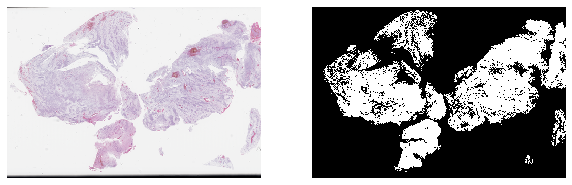

In [9]:
thumbnail = slide.get_thumbnail((500, 500))
cthumbnail = clean_thumbnail(thumbnail)
tissue_mask = (cthumbnail.mean(axis=2) != 255)*1.

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tissue_mask, cmap='Greys_r')
plt.axis('off')

In [10]:
objective_power = int(slide.properties['openslide.objective-power'])

In [11]:
w, h = slide.dimensions

# at 20x its 1000x1000
patch_size = (objective_power/20.)*1000

In [12]:
patch_size

2000.0

In [13]:
mask_hratio = (tissue_mask.shape[0]/h)*patch_size
mask_wratio = (tissue_mask.shape[1]/w)*patch_size

# iterating over patches
patches = []

for i, hi in enumerate(range(0, h, int(patch_size) )):
    
    _patches = []
    for j, wi in enumerate(range(0, w, int(patch_size) )):
        
        # check if patch contains 70% tissue area
        mi = int(i*mask_hratio)
        mj = int(j*mask_wratio)
        
        patch_mask = tissue_mask[mi:mi+int(mask_hratio), mj:mj+int(mask_wratio)]
        
        tissue_coverage = np.count_nonzero(patch_mask)/patch_mask.size
        
        _patches.append({'loc': [i, j], 'wsi_loc': [int(hi), int(wi)], 'tissue_coverage': tissue_coverage})
        
    patches.append(_patches)

In [14]:
# for patch to be considered it should have this much tissue area
tissue_threshold = 0.7

flat_patches = np.ravel(patches)
for patch in tqdm.tqdm(flat_patches):
    
    # ignore patches with less tissue coverage
    if patch['tissue_coverage'] < tissue_threshold:
        continue
    
    # this loc is at the objective power
    h, w = patch['wsi_loc']
    
    # we will go obe level lower, i.e. (objective power / 4)
    # we still need patches at 5x of size 250x250
    # this logic can be modified and may not work properly for images of lower objective power < 20 or greater than 40
    patch_size_5x = int(((objective_power / 4)/5)*250.)
    
    patch_region = slide.read_region((w, h), 1, (patch_size_5x, patch_size_5x)).convert('RGB')
    
    if patch_region.size[0] != 250:
        patch_region = patch_region.resize((250, 250))
    
    histogram = (np.array(patch_region)/255.).reshape((250*250, 3)).mean(axis=0)
    patch['rgb_histogram'] = histogram    

100%|██████████| 3408/3408 [00:41<00:00, 81.45it/s] 


In [15]:
selected_patches_flags = [patch['tissue_coverage'] >= tissue_threshold for patch in flat_patches]
selected_patches = flat_patches[selected_patches_flags]

kmeans_clusters = 9
kmeans = KMeans(n_clusters = kmeans_clusters)
features = np.array([entry['rgb_histogram'] for entry in selected_patches])

kmeans.fit(features)

KMeans(n_clusters=9)

In [16]:
cmap = plt.cm.get_cmap('hsv', kmeans_clusters)

(-0.5, 70.5, 47.5, -0.5)

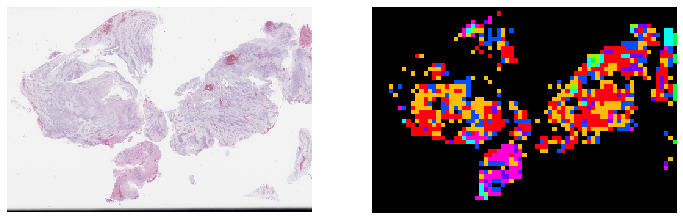

In [17]:
patch_clusters = np.zeros(np.array(patches).shape+(3,))

for patch, label in zip(selected_patches, kmeans.labels_):
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(label)[:3]
    patch['cluster_lbl'] = label

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')

In [18]:
# Another hyperparameter of Yottixel
# Yottixel has been tested with 5, 10, and 15 with 15 performing most optimally
percentage_selected = 15

mosaic = []

for i in range(kmeans_clusters):
    cluster_patches = selected_patches[kmeans.labels_ == i]
    n_selected = max(1, int(len(cluster_patches)*percentage_selected/100.))
    
    km = KMeans(n_clusters=n_selected)
    loc_features = [patch['wsi_loc'] for patch in cluster_patches]
    ds = km.fit_transform(loc_features)
    
    c_selected_idx = []
    for idx in range(n_selected):
        sorted_idx = np.argsort(ds[:, idx])
        
        for sidx in sorted_idx:
            if sidx not in c_selected_idx:
                c_selected_idx.append(sidx)
                mosaic.append(cluster_patches[sidx])
                break

(-0.5, 70.5, 47.5, -0.5)

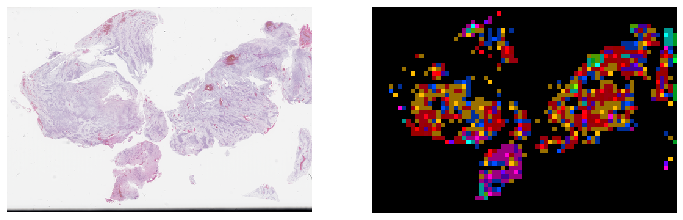

In [19]:
patch_clusters = np.zeros(np.array(patches).shape+(3,))

for patch in selected_patches:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = np.array(cmap(patch['cluster_lbl'])[:3])*0.6
for patch in mosaic:
    patch_clusters[patch['loc'][0], patch['loc'][1], :] = cmap(patch['cluster_lbl'])[:3]
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(patch_clusters)
plt.axis('off')

In [20]:
model = get_dn121_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
29089792/29084464 [==============================] - 0s 0us/step


In [21]:
patch_queue = []
feature_queue = []
batch_size = 20

for patch in tqdm.tqdm(mosaic):
    
    # this loc is at the objective power
    h, w = patch['wsi_loc']
    
    patch_size_20x = int((objective_power/20.)*1000)
    patch_region = slide.read_region((w, h), 0, (patch_size_20x, patch_size_20x)).convert('RGB')
    
    patch_queue.append(np.array(patch_region))
    if len(patch_queue) == batch_size:
        feature_queue.extend(model.predict( np.array(patch_queue) ))
        patch_queue = []
        
if len(patch_queue) != 0:
    padded_arr = np.zeros((batch_size, patch_size_20x, patch_size_20x, 3))
    padded_arr[:len(patch_queue), :, :, :] = np.array(patch_queue)
    feature_queue.extend(model.predict( padded_arr )[:len(patch_queue)])

100%|██████████| 127/127 [02:50<00:00,  1.35s/it]


In [22]:
bob_raw = (np.diff(np.array(feature_queue), axis=1) < 0)*1

In [23]:
bob = BoB(bob_raw)